=== TEXT ANALYSIS PIPELINE ===
Data loaded: 8000 records with feedback
Average feedback length: 32.4 characters

=== PREPROCESSING TEXT ===
After preprocessing: 8000 records remaining

=== SENTIMENT ANALYSIS ===
Sentiment Distribution:
  Positive: 4771 (59.6%)
  Negative: 2413 (30.2%)
  Neutral: 816 (10.2%)

=== TOPIC MODELING ===
Document-term matrix shape: (8000, 48)

=== DISCOVERED TOPICS ===
Topic_1: expensive, expensive feature, feature offered, offered, feature, happy, quality, better
Topic_2: terrible, experience buy, experience, buy, terrible experience, late, late happy, delivery
Topic_3: product, better, product quality, quality, quality better, product satisfied, great, great product
Topic_4: excellent, excellent customer, customer service, customer, service, expectation, met expectation, special
Topic_5: recommend, highly recommend, highly, price happy, worth, purchase, worth price, happy purchase

Topic Distribution:
  Topic 1: 816 documents (10.2%)
  Topic 2: 1579 documen

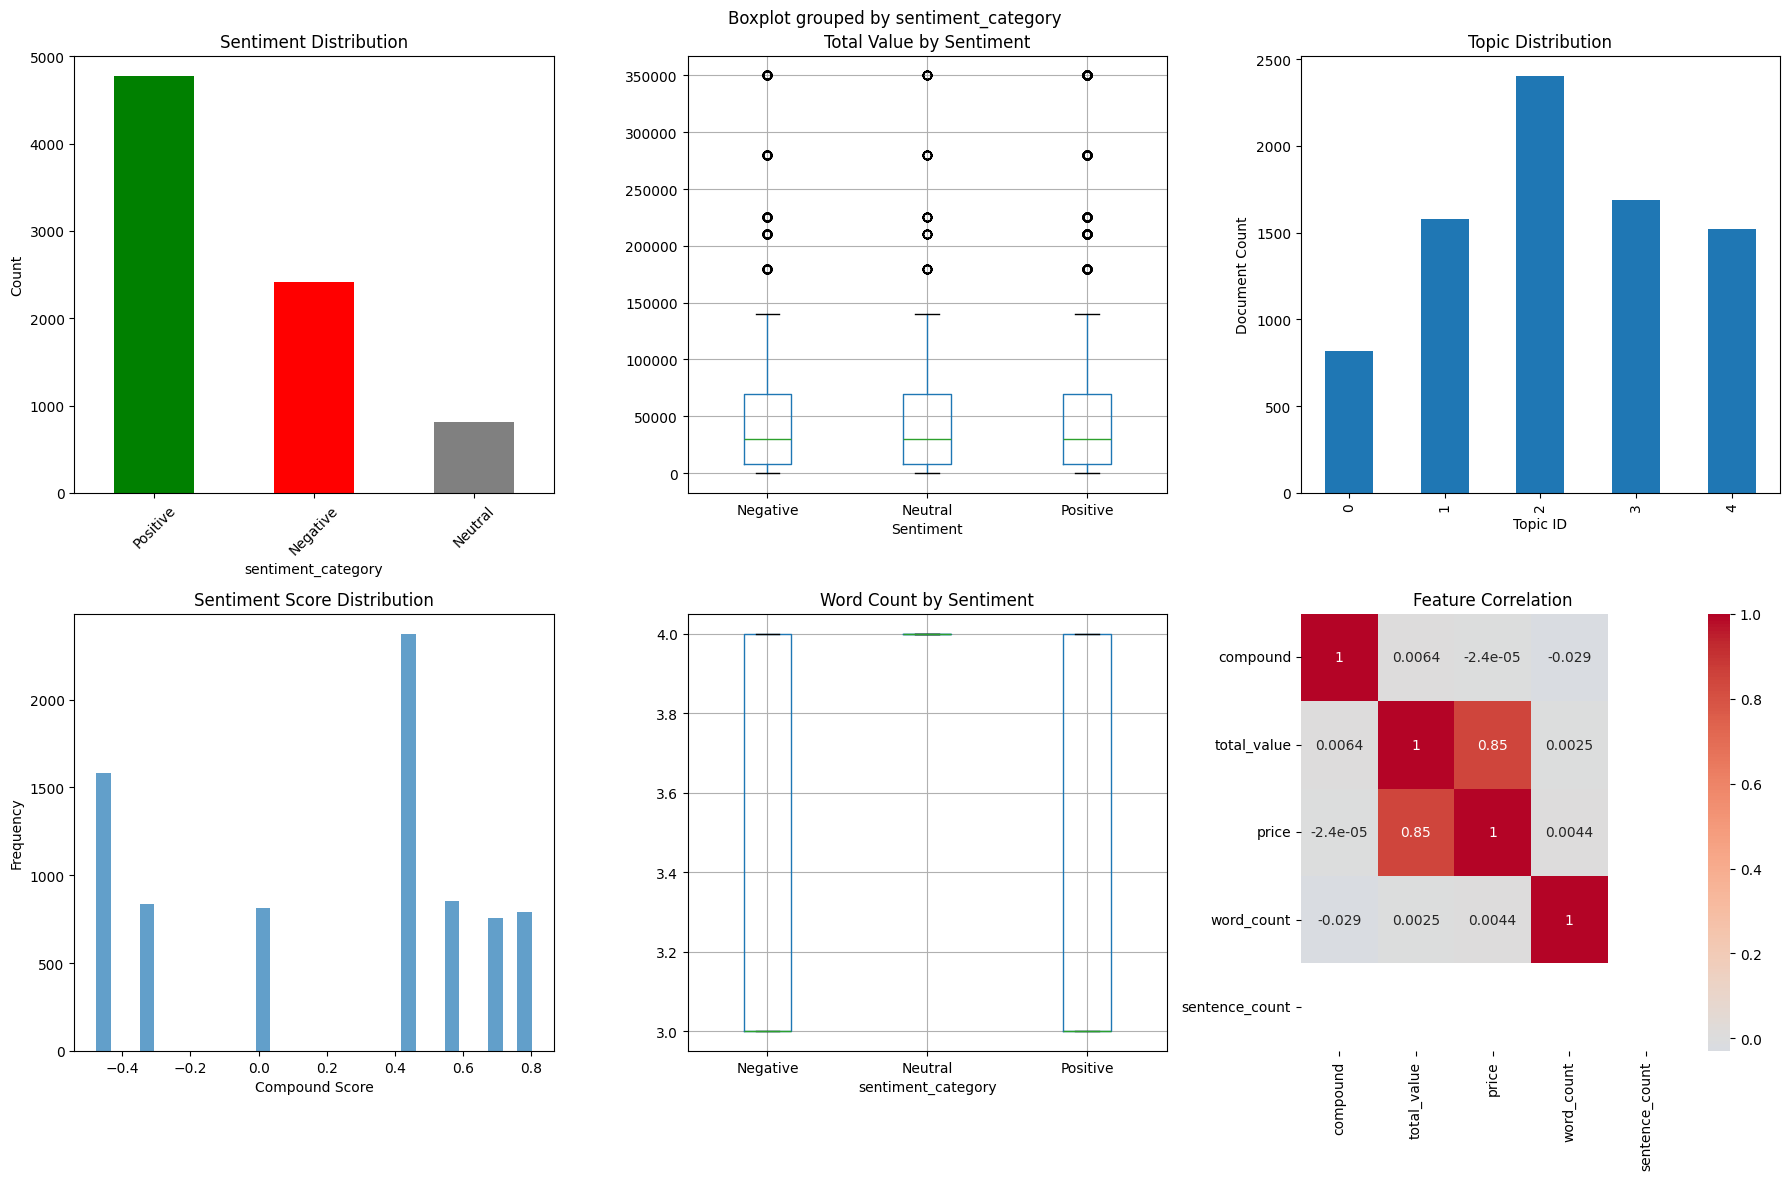


=== GENERATING WORD CLOUDS ===

=== BUSINESS INSIGHTS ===
High-value customer sentiment (top 20%):
  Positive: 60.5%
  Negative: 30.2%
  Neutral: 9.3%

Topic-Sentiment Cross Analysis:
sentiment_category  Negative  Neutral  Positive
dominant_topic                                 
0                          0      816         0
1                       1579        0         0
2                          0        0      2400
3                        834        0       853
4                          0        0      1518

=== SAVING RESULTS ===
=== TEXT ANALYSIS COMPLETE ===
Enhanced dataset saved: ../data/customer_feedback_analyzed.csv
Topic assignments saved: ../data/feedback_topics.csv
Discovered topics saved: ../data/discovered_topics.csv
Sentiment keywords saved: ../data/sentiment_keywords.csv

=== SUMMARY STATISTICS ===
• Total feedback analyzed: 8000
• Average sentiment score: 0.209
• Most positive sentiment: 0.802
• Most negative sentiment: -0.477
• Topics discovered: 5
• Average wor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
nltk_downloads = [
    'vader_lexicon', 'stopwords', 'punkt', 'wordnet', 
    'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words'
 ]
for item in nltk_downloads:
    try:
        nltk.data.find(f'tokenizers/{item}')
    except LookupError:
        try:
            nltk.download(item, quiet=True)
        except:
            print(f"Could not download {item}")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud
print("=== TEXT ANALYSIS PIPELINE ===")
df = pd.read_csv("../data/customer_intelligence_dataset.csv")
df['feedback_text'] = df['feedback_text'].fillna('').astype(str)
df = df[df['feedback_text'].str.len() > 0].copy()
print(f"Data loaded: {len(df)} records with feedback")
print(f"Average feedback length: {df['feedback_text'].str.len().mean():.1f} characters")

In [ ]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
    def clean_text(self, text):
        if pd.isna(text) or text == '':
            return ''
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())
        return text
    def tokenize_and_lemmatize(self, text):
        if not text:
            return []
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words and len(token) > 2]
        return tokens
    def preprocess(self, text):
        cleaned = self.clean_text(text)
        tokens = self.tokenize_and_lemmatize(cleaned)
        return ' '.join(tokens)
preprocessor = TextPreprocessor()
df['feedback_clean'] = df['feedback_text'].apply(preprocessor.preprocess)
df['feedback_tokens'] = df['feedback_text'].apply(preprocessor.tokenize_and_lemmatize)
df['token_count'] = df['feedback_tokens'].apply(len)
df = df[df['token_count'] >= 3].copy()
print(f"After preprocessing: {len(df)} records remaining")

In [ ]:
sia = SentimentIntensityAnalyzer()
def analyze_sentiment(text):
    if not text or pd.isna(text):
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    scores = sia.polarity_scores(text)
    return scores
sentiment_scores = df['feedback_text'].apply(analyze_sentiment)
sentiment_df = pd.DataFrame(sentiment_scores.tolist())
df = pd.concat([df, sentiment_df], axis=1)
def categorize_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
df['sentiment_category'] = df['compound'].apply(categorize_sentiment)
sentiment_counts = df['sentiment_category'].value_counts()
for sentiment, count in sentiment_counts.items():
    print(f"  {sentiment}: {count} ({count/len(df)*100:.1f}%)")

In [ ]:
texts_for_topics = df['feedback_clean'].tolist()
texts_for_topics = [text for text in texts_for_topics if len(text.split()) >= 3]
vectorizer = TfidfVectorizer(max_features=100, max_df=0.8, min_df=2, ngram_range=(1, 2), stop_words='english')
doc_term_matrix = vectorizer.fit_transform(texts_for_topics)
feature_names = vectorizer.get_feature_names_out()
print(f"Document-term matrix shape: {doc_term_matrix.shape}")
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=20, learning_method='online')
lda.fit(doc_term_matrix)
def display_topics(model, feature_names, num_top_words=8):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-num_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[f'Topic_{topic_idx+1}'] = top_words
    return topics
topics = display_topics(lda, feature_names)
for topic_name, words in topics.items():
    print(f"{topic_name}: {', '.join(words)}")
doc_topic_probs = lda.transform(doc_term_matrix)
df_topics = df.iloc[:len(doc_topic_probs)].copy()
df_topics['dominant_topic'] = doc_topic_probs.argmax(axis=1)
df_topics['topic_probability'] = doc_topic_probs.max(axis=1)
topic_counts = df_topics['dominant_topic'].value_counts().sort_index()
for topic_id, count in topic_counts.items():
    print(f"  Topic {topic_id+1}: {count} documents ({count/len(df_topics)*100:.1f}%)")

In [ ]:
def get_top_words_by_sentiment(df, sentiment, n_words=10):
    sentiment_texts = df[df['sentiment_category'] == sentiment]['feedback_tokens']
    all_words = [word for tokens in sentiment_texts for word in tokens]
    return Counter(all_words).most_common(n_words)
sentiment_keywords = {}
for sentiment in ['Positive', 'Negative', 'Neutral']:
    if sentiment in df['sentiment_category'].values:
        keywords = get_top_words_by_sentiment(df, sentiment, 10)
        sentiment_keywords[sentiment] = keywords
        for word, count in keywords:
            print(f"  {word}: {count}")
def extract_text_features(text, tokens):
    if not text or not tokens:
        return {'word_count': 0, 'avg_word_length': 0, 'sentence_count': 0, 'exclamation_count': 0, 'question_count': 0, 'uppercase_ratio': 0}
    features = {}
    features['word_count'] = len(tokens)
    features['avg_word_length'] = np.mean([len(word) for word in tokens]) if tokens else 0
    features['sentence_count'] = len(sent_tokenize(text))
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    uppercase_chars = sum(1 for c in text if c.isupper())
    total_chars = len(text)
    features['uppercase_ratio'] = uppercase_chars / total_chars if total_chars > 0 else 0
    return features
text_features = df.apply(lambda row: extract_text_features(row['feedback_text'], row['feedback_tokens']), axis=1)
text_features_df = pd.DataFrame(text_features.tolist())
df_enhanced = pd.concat([df, text_features_df], axis=1)

In [ ]:
sentiment_business = df_enhanced.groupby('sentiment_category').agg({
    'total_value': ['mean', 'sum', 'count'],
    'price': 'mean',
    'quantity': 'mean',
    'age': 'mean',
    'compound': 'mean'
}).round(2)
print(sentiment_business)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sentiment_counts.plot(kind='bar', ax=axes[0,0], color=['green', 'red', 'gray'])
axes[0,0].set_title('Sentiment Distribution')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)
df_enhanced.boxplot(column='total_value', by='sentiment_category', ax=axes[0,1])
axes[0,1].set_title('Total Value by Sentiment')
axes[0,1].set_xlabel('Sentiment')
topic_counts.plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('Topic Distribution')
axes[0,2].set_xlabel('Topic ID')
axes[0,2].set_ylabel('Document Count')
axes[1,0].hist(df_enhanced['compound'], bins=30, alpha=0.7)
axes[1,0].set_title('Sentiment Score Distribution')
axes[1,0].set_xlabel('Compound Score')
axes[1,0].set_ylabel('Frequency')
df_enhanced.boxplot(column='word_count', by='sentiment_category', ax=axes[1,1])
axes[1,1].set_title('Word Count by Sentiment')
corr_features = ['compound', 'total_value', 'price', 'word_count', 'sentence_count']
corr_matrix = df_enhanced[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Feature Correlation')
plt.tight_layout()
plt.show()

In [ ]:
if 'wordcloud' in globals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for idx, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
        if sentiment in df['sentiment_category'].values:
            sentiment_text = ' '.join(df[df['sentiment_category'] == sentiment]['feedback_clean'])
            if sentiment_text.strip():
                wordcloud = WordCloud(width=400, height=300, background_color='white', colormap='viridis' if sentiment == 'Positive' else 'Reds' if sentiment == 'Negative' else 'gray').generate(sentiment_text)
                axes[idx].imshow(wordcloud, interpolation='bilinear')
                axes[idx].set_title(f'{sentiment} Feedback')
                axes[idx].axis('off')
    plt.tight_layout()
    plt.show()
high_value_threshold = df_enhanced['total_value'].quantile(0.8)
high_value_customers = df_enhanced[df_enhanced['total_value'] > high_value_threshold]
high_value_sentiment = high_value_customers['sentiment_category'].value_counts(normalize=True)
for sentiment, ratio in high_value_sentiment.items():
    print(f"  {sentiment}: {ratio*100:.1f}%")
topic_sentiment_crosstab = pd.crosstab(df_topics['dominant_topic'], df_topics['sentiment_category'])
print(topic_sentiment_crosstab)
df_enhanced.to_csv("../data/customer_feedback_analyzed.csv", index=False)
df_topics[['customer_id', 'feedback_text', 'sentiment_category', 'compound', 'dominant_topic', 'topic_probability']].to_csv("../data/feedback_topics.csv", index=False)
topics_df = pd.DataFrame([(topic, ', '.join(words)) for topic, words in topics.items()], columns=['Topic', 'Keywords'])
topics_df.to_csv("../data/discovered_topics.csv", index=False)
sentiment_keywords_df = []
for sentiment, keywords in sentiment_keywords.items():
    for word, count in keywords:
        sentiment_keywords_df.append({'sentiment': sentiment, 'word': word, 'count': count})
pd.DataFrame(sentiment_keywords_df).to_csv("../data/sentiment_keywords.csv", index=False)
print(f"Enhanced dataset saved: ../data/customer_feedback_analyzed.csv")
print(f"Topic assignments saved: ../data/feedback_topics.csv")
print(f"Discovered topics saved: ../data/discovered_topics.csv")
print(f"Sentiment keywords saved: ../data/sentiment_keywords.csv")
print(f"• Total feedback analyzed: {len(df_enhanced)}")
print(f"• Average sentiment score: {df_enhanced['compound'].mean():.3f}")
print(f"• Most positive sentiment: {df_enhanced['compound'].max():.3f}")
print(f"• Most negative sentiment: {df_enhanced['compound'].min():.3f}")
print(f"• Topics discovered: {n_topics}")
print(f"• Average words per feedback: {df_enhanced['word_count'].mean():.1f}")